In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csr_matrix

import celeri

plt.rcParams["text.usetex"] = False # Plotting the global model is much much faster with tex fonts turned off

# Read in data files and do basic processing

In [3]:
# Japan example
command_file_name = "../data/command/japan_command.json"
lon_range = (130.0, 150.0)
lat_range = (30.0, 45.0)

# Western North America example
# command_file_name = "../data/command/western_north_america_command.json"
# lon_range = (225.0, 250.0)
# lat_range = (30.0, 52.0)

In [4]:
command, segment, block, meshes, station, mogi, sar = celeri.read_data(command_file_name)
celeri.create_output_folder(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar) # Not sure this works correctly

# Get elastic operators and TDE smoothing operators

In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

Using precomputed elastic operators


# Calculate non-elastic operators

In [6]:
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(station)
operators.global_float_block_rotation = celeri.get_global_float_block_rotation_partials(station)
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(assembly, block, command)
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(assembly, segment, block, command)
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(segment, block)
operators.block_strain_rate_to_velocities, strain_rate_block_index = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(mogi, station, command)
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Plot input data

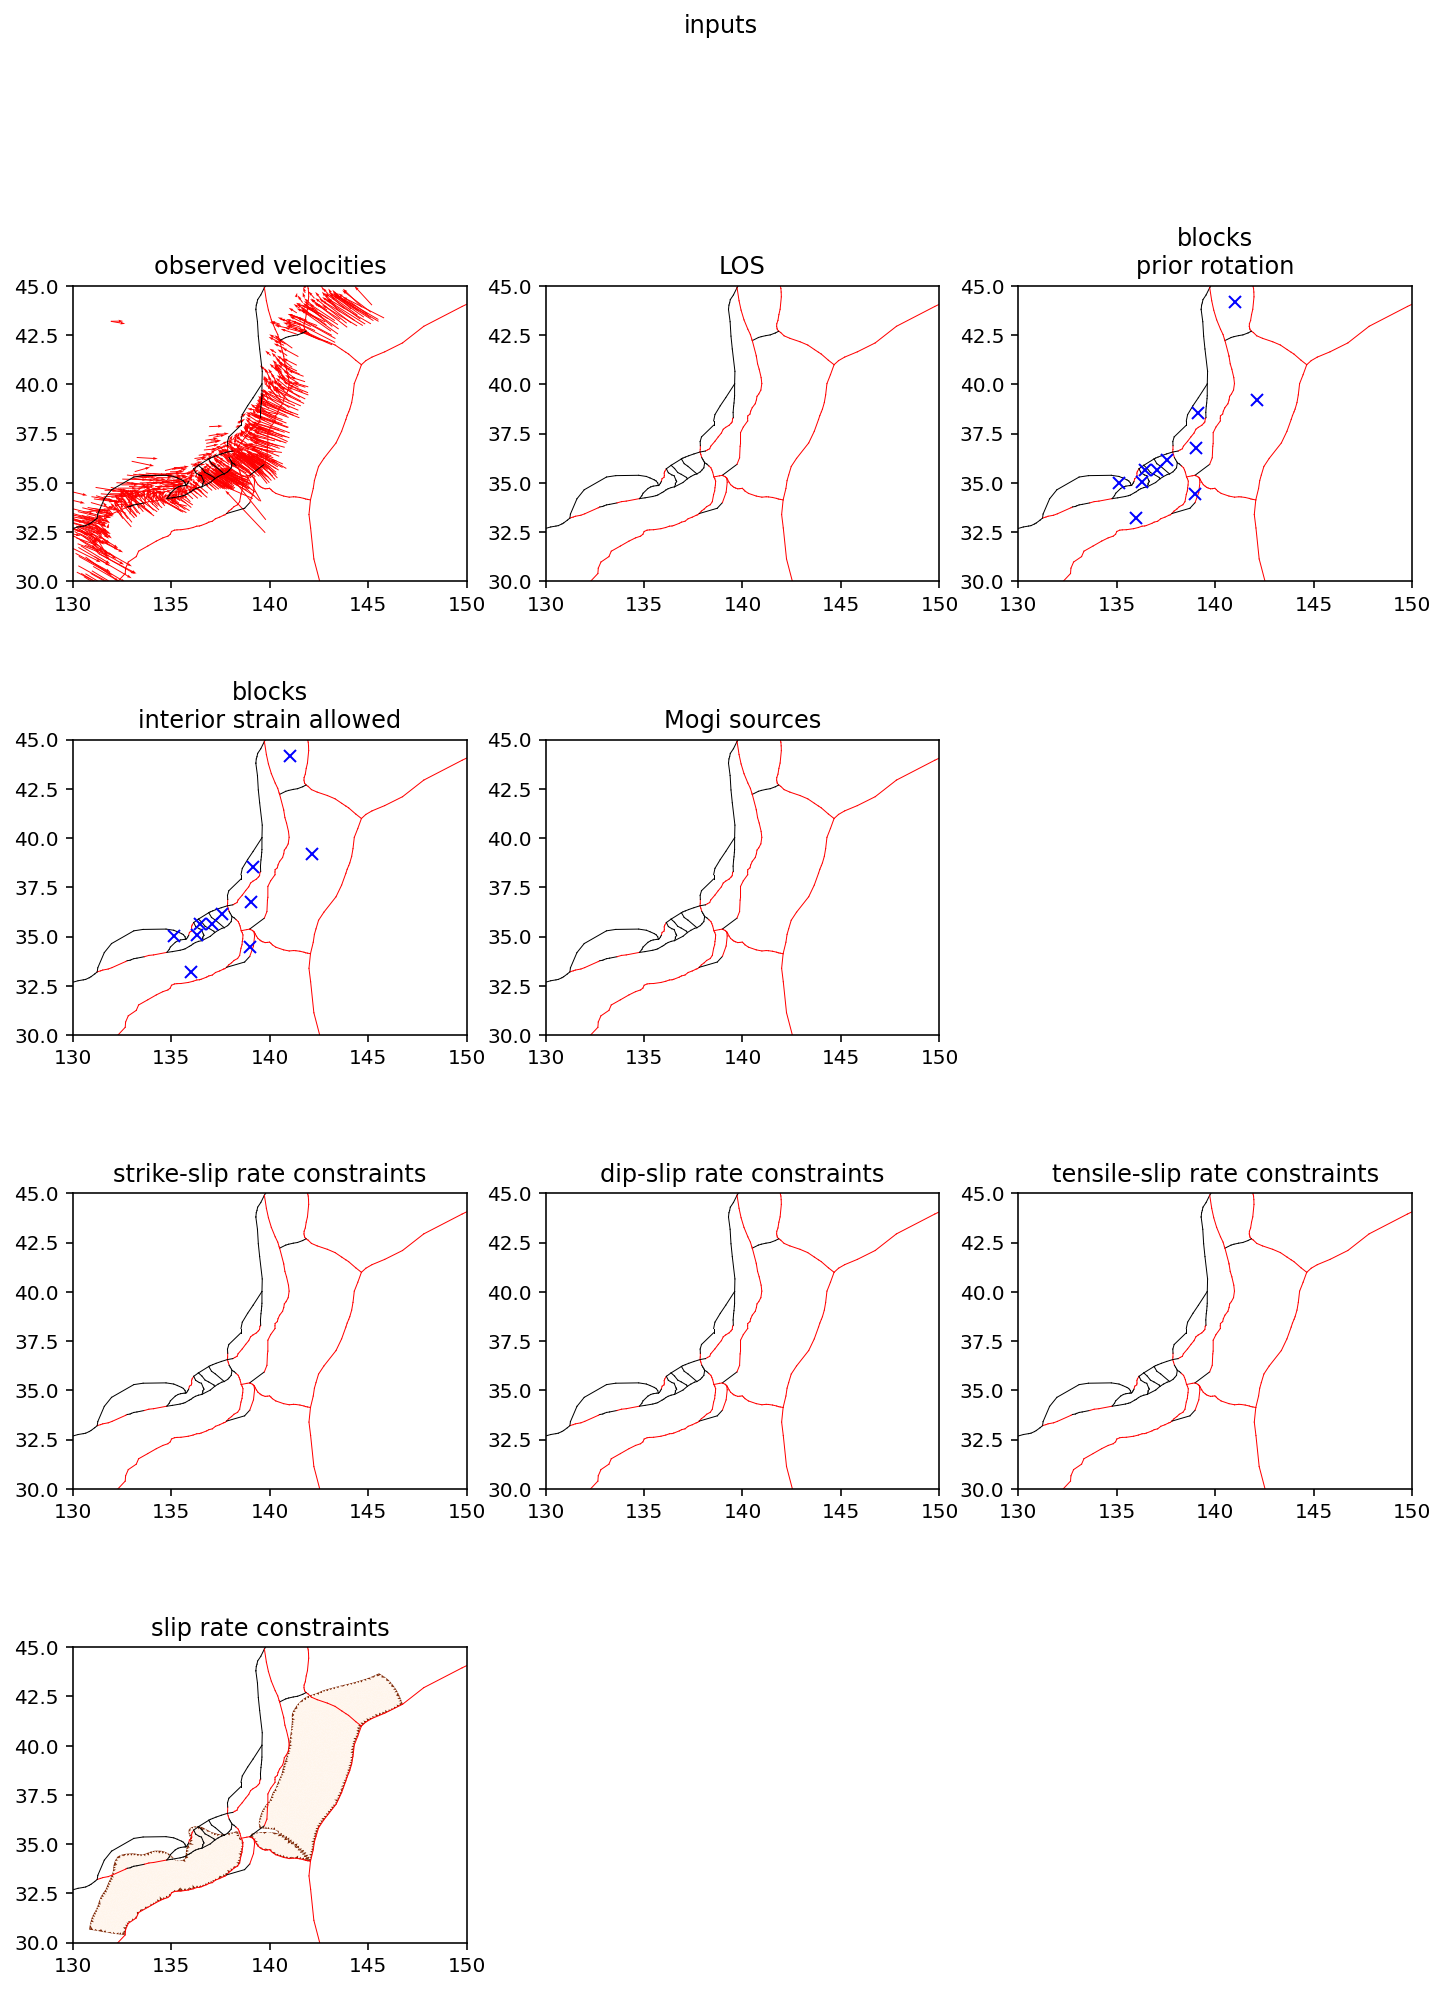

In [7]:
celeri.plot_input_summary(segment, station, block, meshes, mogi, sar, lon_range=lon_range, lat_range=lat_range, quiver_scale=1e2)

# Estimate block model parameters (dense)

In [8]:
_, estimation = celeri.assemble_and_solve_dense(command, assembly, operators, station, block, meshes)
index = celeri.get_index(assembly, station, block, meshes)
celeri.post_process_estimation(estimation, operators, station, index)
# celeri.write_output(command, estimation, station, segment, block, meshes)

# Plot model summary

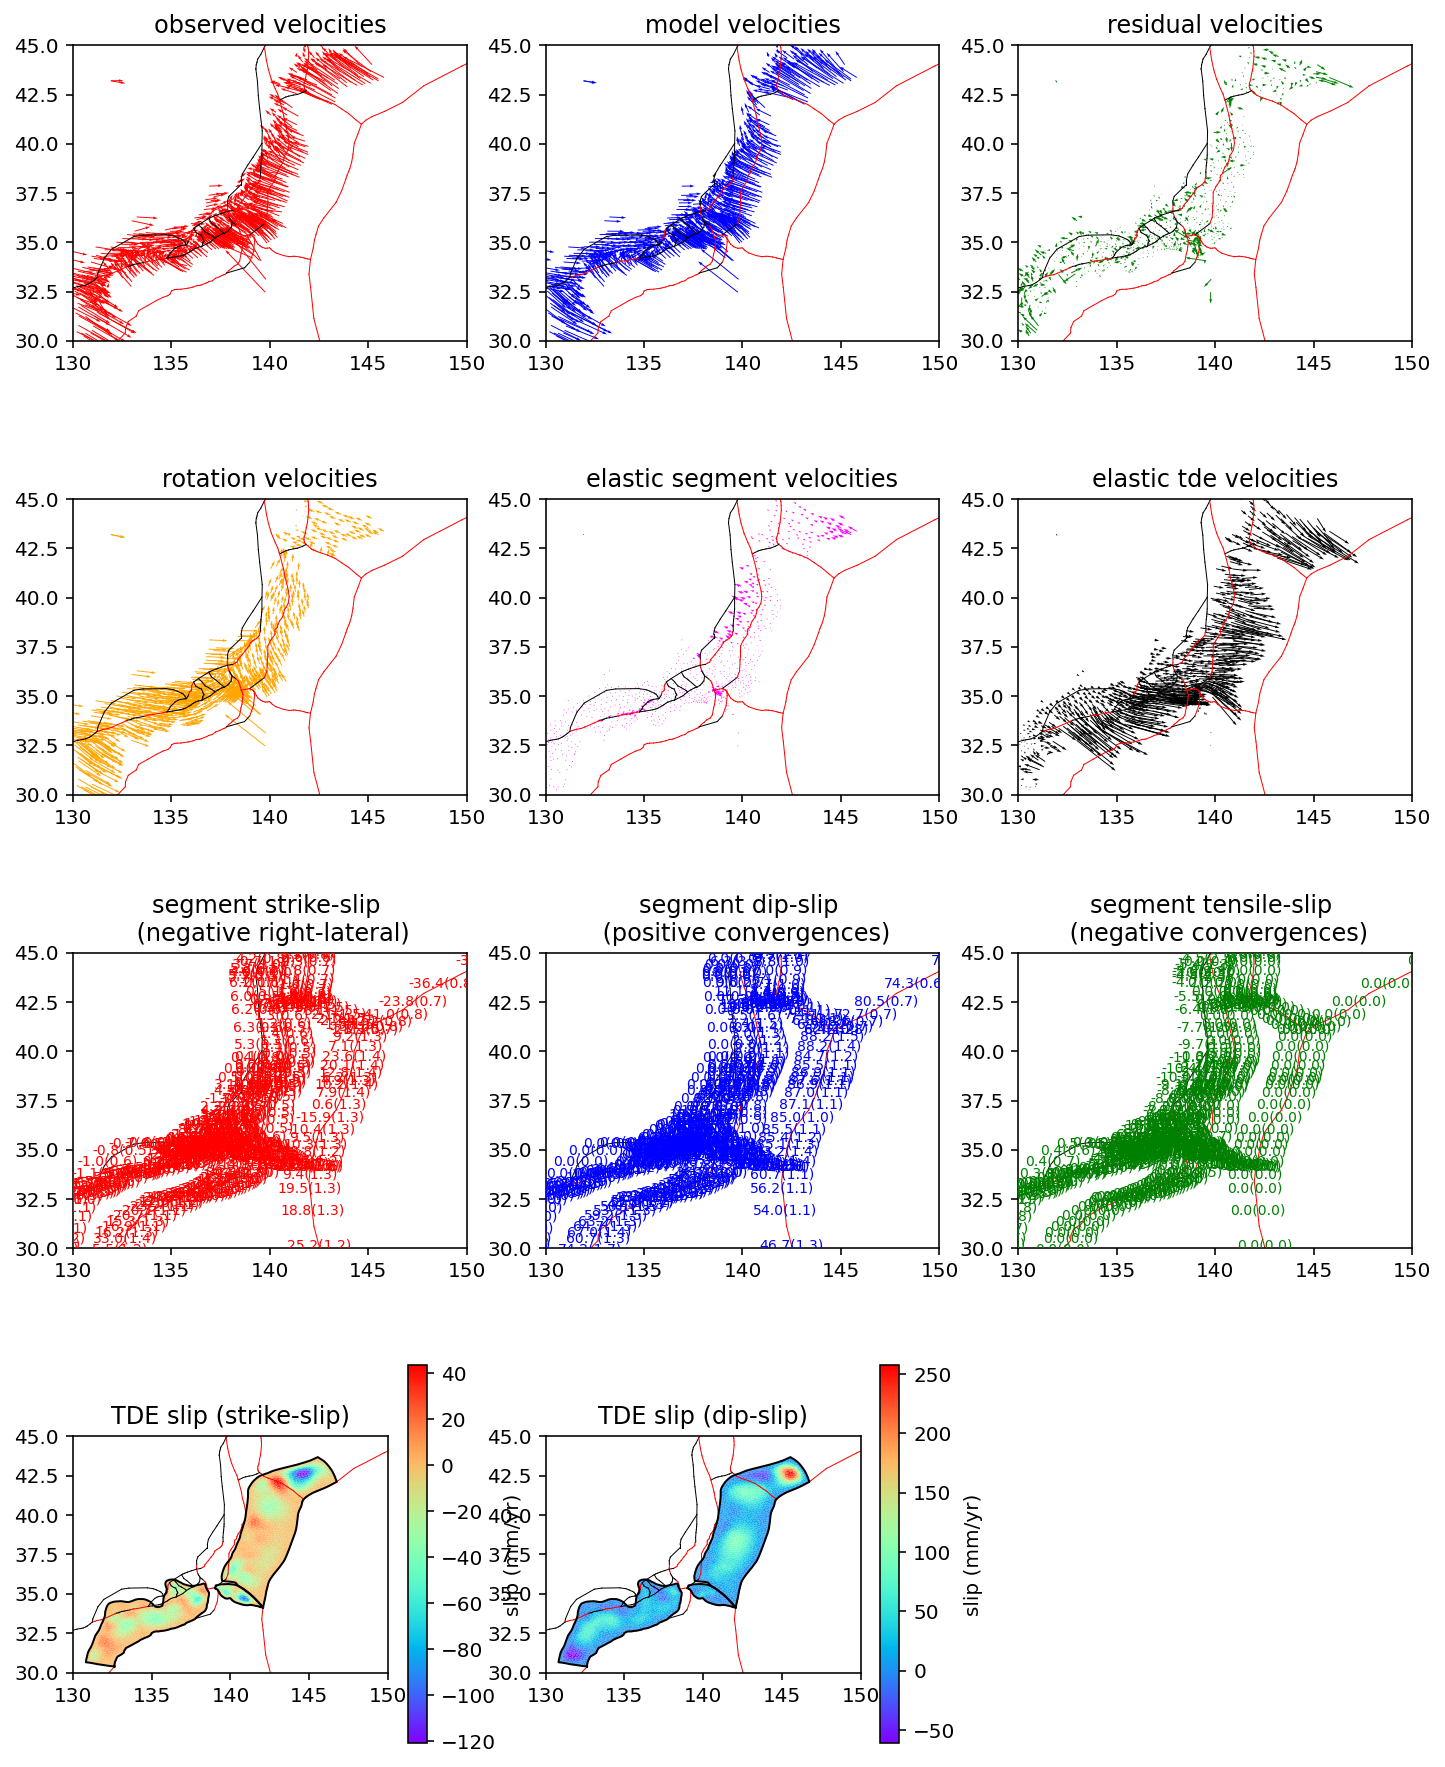

In [9]:
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=lon_range, lat_range=lat_range, quiver_scale=1e2)

# Calculate col_norms and H for each mesh here.

In [10]:
# Data and data weighting vector
weighting_vector = celeri.get_weighting_vector(command, station, meshes, index)
data_vector = celeri.get_data_vector(assembly, index)

# Apply data weighting
data_vector = data_vector * np.sqrt(weighting_vector)

from celeri.hmatrix import build_hmatrix_from_mesh_tdes

# Cast all block submatrices to sparse
sparse_block_motion_okada_faults = csr_matrix(operators.rotation_to_velocities[index.station_row_keep_index, :] - operators.rotation_to_slip_rate_to_okada_to_velocities[index.station_row_keep_index, :])
sparse_block_motion_constraints = csr_matrix(operators.block_motion_constraints)
sparse_block_slip_rate_constraints = csr_matrix(operators.slip_rate_constraints)

# Calculate column normalization vector for blocks
operator_block_only = celeri.get_full_dense_operator_block_only(operators, index)
weighting_vector_block_only = weighting_vector[0:operator_block_only.shape[0]][:, None]
col_norms = np.linalg.norm(operator_block_only * np.sqrt(weighting_vector_block_only), axis=0)

# Create lists for all TDE matrices per mesh
H = []
for i in range(len(meshes)):
    # Get full TDE to velocity matrix for current mesh
    tde_to_velocities = celeri.get_elastic_operator_single_mesh(meshes, station, command, i)
    
    # H-matrix representation
    H.append(build_hmatrix_from_mesh_tdes(
        meshes[i],
        station,
        tde_to_velocities,
        1e-6,
        min_separation=1.25,
        min_pts_per_box=20,
    ))
    print(f"mesh {i} ({meshes[i].name}) H-matrix compression ratio: {H[i].report_compression_ratio():0.4f}")

    # Case smoothing matrices and tde slip rate constraints to sparse
    smoothing_keep_index = celeri.get_keep_index_12(operators.smoothing_matrix[i].shape[0])
    operators.smoothing_matrix[i] = csr_matrix(operators.smoothing_matrix[i][smoothing_keep_index, :][:, smoothing_keep_index])    
    operators.tde_slip_rate_constraints[i] = csr_matrix(operators.tde_slip_rate_constraints[i])

    # Eliminate unused columns and rows of TDE to velocity matrix
    tde_to_velocities = np.delete(tde_to_velocities, np.arange(2, tde_to_velocities.shape[0], 3), axis=0)
    tde_to_velocities = np.delete(tde_to_velocities, np.arange(2, tde_to_velocities.shape[1], 3), axis=1)

    # Calculate column normalization vector current TDE mesh
    weighting_vector_no_zero_rows = celeri.get_weighting_vector_single_mesh_for_col_norms(command, station, meshes, index, i)
    current_tde_mesh_columns_full_no_zero_rows = np.vstack((-tde_to_velocities, operators.smoothing_matrix[i].toarray(), operators.tde_slip_rate_constraints[i].toarray())) * np.sqrt(weighting_vector_no_zero_rows[:, None])

    # Concatenate everthing we need for col_norms
    col_norms_current_tde_mesh = np.linalg.norm(current_tde_mesh_columns_full_no_zero_rows, axis=0)
    col_norms = np.hstack((col_norms, col_norms_current_tde_mesh))

Using precomputed elastic operators
Saving elastic to velocity matrices to :../data/operators/japan_elastic_operators.hdf5
mesh 0 (../data/mesh/nankai.msh) H-matrix compression ratio: 0.5898
Using precomputed elastic operators
Saving elastic to velocity matrices to :../data/operators/japan_elastic_operators.hdf5
mesh 1 (../data/mesh/japan.msh) H-matrix compression ratio: 0.4711
Using precomputed elastic operators
Saving elastic to velocity matrices to :../data/operators/japan_elastic_operators.hdf5
mesh 2 (../data/mesh/sagami.msh) H-matrix compression ratio: 0.4884


In [11]:
def matvec(v):
    """ Build matvec (matrix vector product) operator for 
    scipy.sparse.linalg.LinearOperator.  This returns A * u

    BJM: Should we be passing in: W, X, index, etc. or let them be known from the outer scope???
    TBT: This will depend on how we integrate this into celeri and which
    variable we're talking about. For example, we should stop using X.shape
    entirely because that matrix won't exist in a fully sparse/hmatrix
    implementation!
    One design that I would probably lean towards
    would be something like:
    def build_sparse_hmatrix_linear_operator(operators,...):
        sparse_block_motion_okada_faults = ...
        define_other_precomputable_vars_here = ...

        def matvec(v):
            # use vars from the outer scope
        def rmatvec(v):
            # use vars from the outer scope

        return scipy.sparse.linalg.LinearOperator(X.shape, matvec=matvec, rmatvec=rmatvec)
        
    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # BJM: Weight the data vector
    # TBT: It's important to remember to keep the input and output weighting
    # conceptually separate since the "out * np.sqrt(W)" will actually change
    # the solution to the least squares problem whereas the "v / col_norms"
    # preconditioning step is a reversible change to the solution (which is the
    # point since preconditioning should not change the solution!!)
    v_scaled = v / col_norms 

    # Make storage for output
    # out = np.zeros(X.shape[0])
    out = np.zeros(index.n_operator_rows)
    block_rotations = v_scaled[index.start_block_col : index.end_block_col]

    # Okada
    out[index.start_station_row : index.end_station_row] += sparse_block_motion_okada_faults.dot(block_rotations)

    # Block motion constraints
    out[index.start_block_constraints_row : index.end_block_constraints_row] += sparse_block_motion_constraints.dot(block_rotations)

    # Slip rate constraints
    out[index.start_slip_rate_constraints_row:index.end_slip_rate_constraints_row] += sparse_block_slip_rate_constraints.dot(block_rotations)

    # Loop over TDE meshes
    # for i in range(len(meshes)):
    for i in range(len(meshes)):
        tde_velocities = v_scaled[index.start_tde_col[i] : index.end_tde_col[i]]

        # Insert TDE to velocity matrix
        out[index.start_station_row : index.end_station_row] += H[i].dot(tde_velocities)

        # TDE smoothing
        out[index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i]] += operators.smoothing_matrix[i].dot(tde_velocities)

        # TDE slip rate constraints
        out[index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i]] += operators.tde_slip_rate_constraints[i].dot(tde_velocities)

    # Weight!
    return out * np.sqrt(weighting_vector)

In [12]:
def rmatvec(u):
    """ Build rmatvec (matrix vector product) operator for 
    scipy.sparse.linalg.LinearOperator.  This returns:
    Returns A^H * v, where A^H is the conjugate transpose of A
    for a candidate state vector, u.  We do this because
    with the h-matrix approach we no longer have the full matrix
    so we can't take the transpose all at once.

    Args:
        u (nd.array): Candidate state vector

    Returns:
        out (nd.array): Predicted data vector
    """

    # Weight the data vector
    u_weighted = u * np.sqrt(weighting_vector)

    # Storage for output
    # out = np.zeros(X.shape[1])
    out = np.zeros(index.n_operator_cols)

    # Select subset of weighted data for the observed velocities
    station_rows = u_weighted[index.start_station_row : index.end_station_row]
    block_constraints = u_weighted[index.start_block_constraints_row : index.end_block_constraints_row]

    # Select subset of weighted data for the fault slip rate constraints
    slip_rate_constraints = u_weighted[index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row]

    # Okada and block rotation contribution to data vector
    out[index.start_block_col : index.end_block_col] += station_rows @ sparse_block_motion_okada_faults

    # Block motion constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += block_constraints @ sparse_block_motion_constraints

    # Fault slip rate constraints contribution to data vector
    out[index.start_block_col : index.end_block_col] += slip_rate_constraints @ sparse_block_slip_rate_constraints

    for i in range(len(meshes)):
        # Select subset of weighted data for the TDE smoothing
        tde_smoothing = u_weighted[index.start_tde_smoothing_row[i] : index.end_tde_smoothing_row[i]]

        # Select subset of weighted data for the TDE slip rate constraints
        tde_slip_rate = u_weighted[index.start_tde_constraint_row[i] : index.end_tde_constraint_row[i]]

        # Hmatrix (TDEs to velocities)
        out[index.start_tde_col[i] : index.end_tde_col[i]] += H[i].transpose_dot(station_rows)

        # TDE smoothing contribution to data vector
        out[index.start_tde_col[i] : index.end_tde_col[i]] += tde_smoothing @ operators.smoothing_matrix[i]

        # TDE slip rate constraint contributions to data vector
        out[index.start_tde_col[i] : index.end_tde_col[i]] += tde_slip_rate @ operators.tde_slip_rate_constraints[i]

    # Weight
    return out / col_norms

In [13]:
# Instantiate the scipy the linear operator for the iterative solver to use
op = scipy.sparse.linalg.LinearOperator((index.n_operator_rows, index.n_operator_cols), matvec=matvec, rmatvec=rmatvec)

# Solve the linear system
sparse_hmatrix_solution = scipy.sparse.linalg.lsmr(op, data_vector, atol=command.atol, btol=command.btol)

# Correct the solution for the col_norms preconditioning.
sparse_hmatrix_state_vector = sparse_hmatrix_solution[0] / col_norms

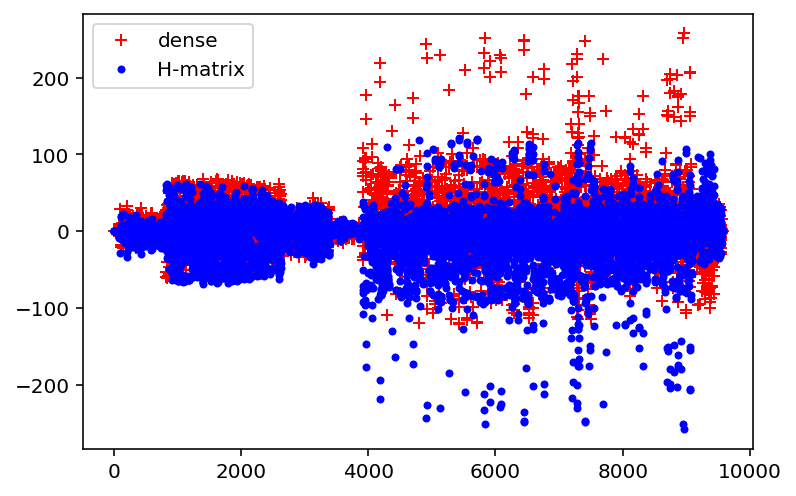

In [14]:
plt.figure()
plt.plot(estimation.state_vector, "r+", label="dense")
plt.plot(sparse_hmatrix_state_vector, "b.", label="H-matrix")
plt.legend()
plt.show()

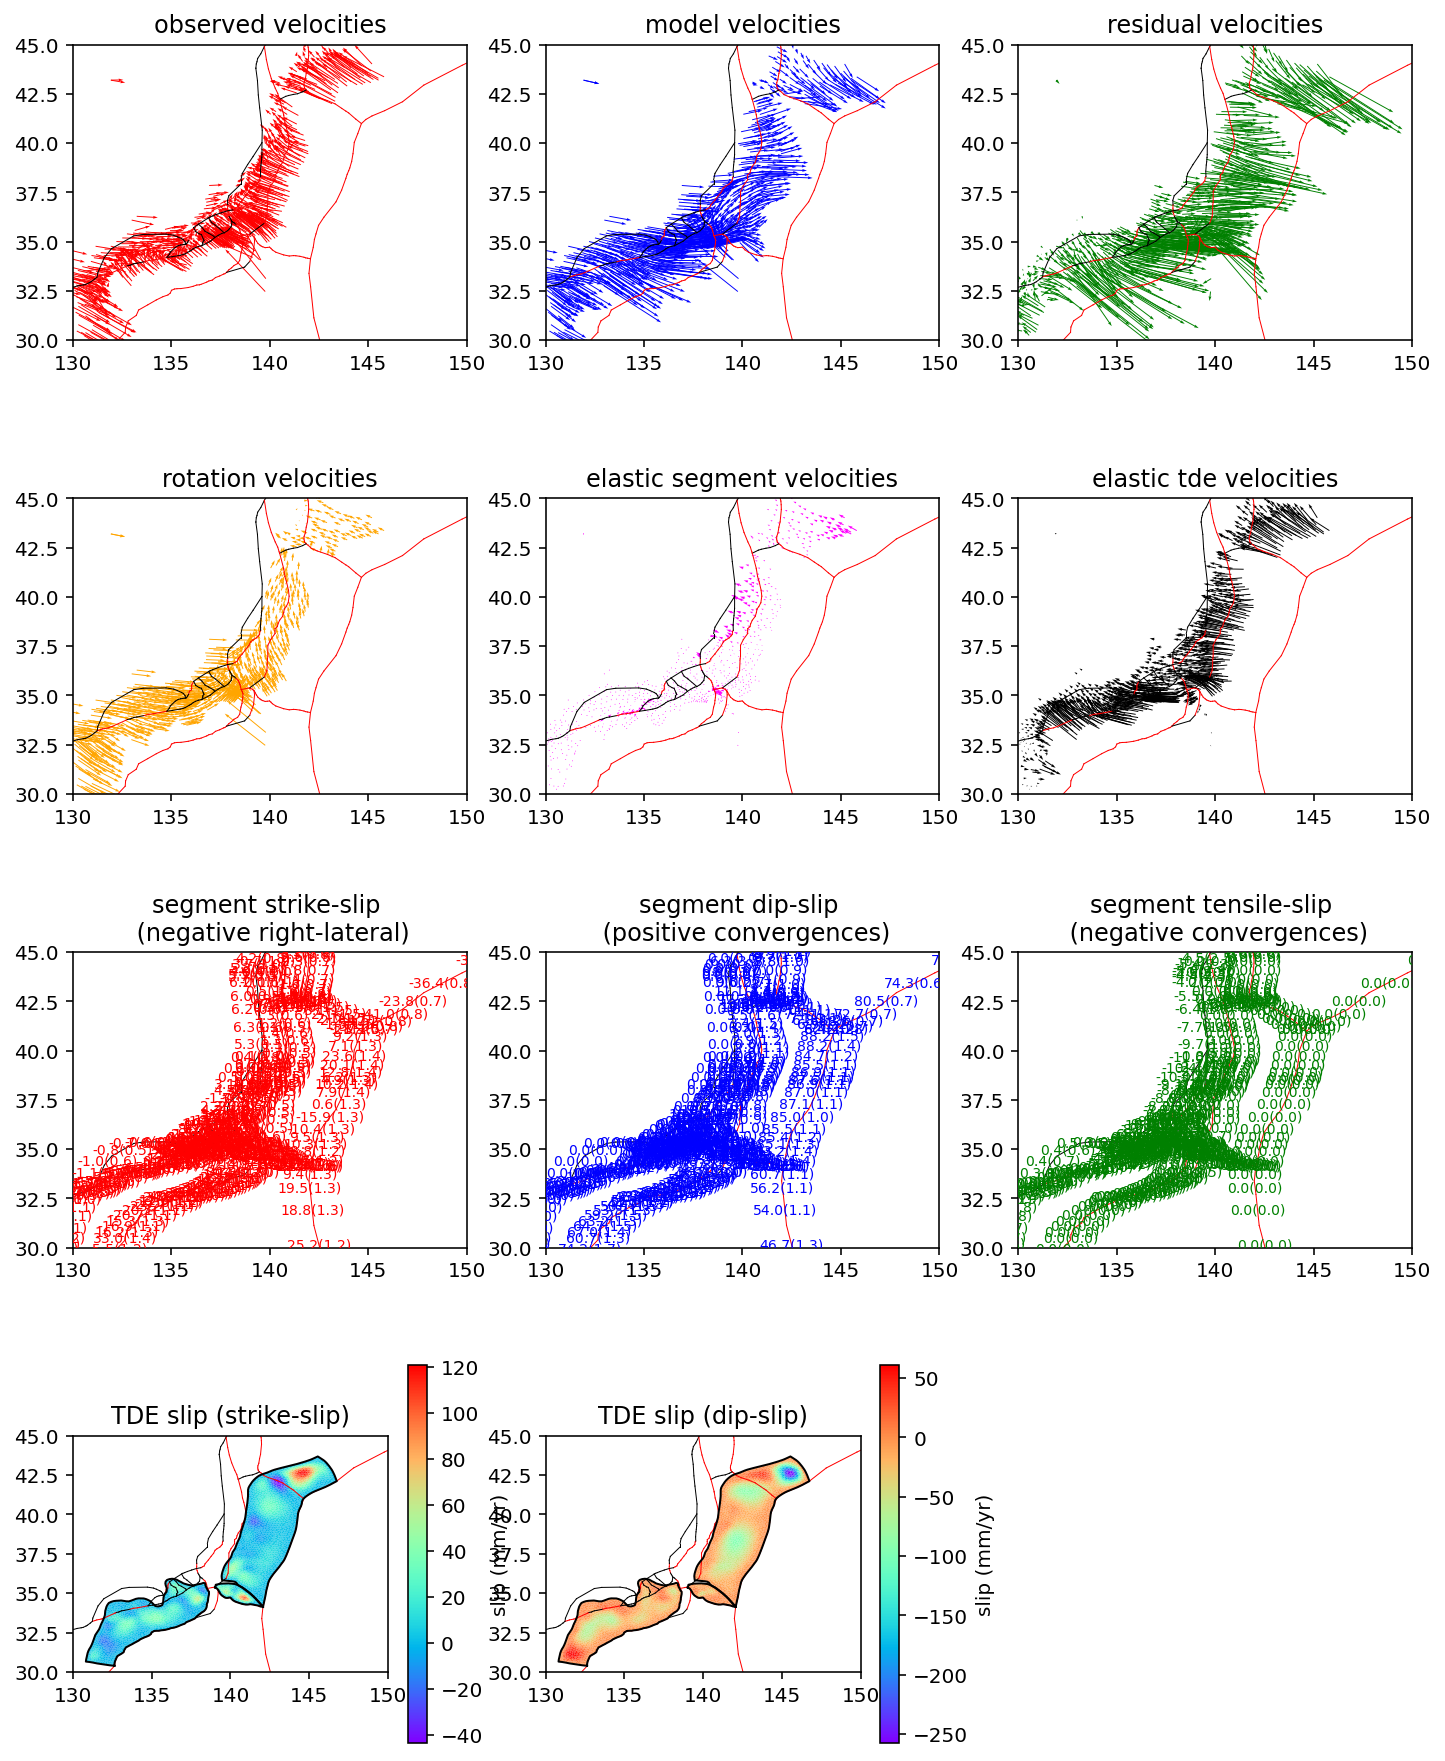

In [15]:
estimation.state_vector = sparse_hmatrix_state_vector
# estimation.operator = op
celeri.post_process_estimation(estimation, operators, station, index)
celeri.plot_estimation_summary(segment, station, meshes, estimation, lon_range=lon_range, lat_range=lat_range, quiver_scale=1e2)

In [16]:
# TODO: Need to create a version of celeri.post_process_estimation(estimation, operators, station, index)
# that is built for the sparse operator.
# Setting estimation.operator = op is a start
# Also we need to pass the sparse version of the operators

# TODO: Need to move matvec and rmatvec to hmatrix.py
# Also need to figure out what variables need to be passed to them explicitly
